# Predicción de Temperaturas

La idea de este proyecto es predecir las temperaturas desde un set de datos y hacer una comparativa entre distintos modelos de predicción LGBM, Conv1D y GRU. 

In [5]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np 
import seaborn as sns

2023-07-23 23:49:27.958959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 23:49:28.121884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-23 23:49:28.121934: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-23 23:49:28.170811: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-23 23:49:30.434389: W tensorflow/stream_executor/pla

Extraemos data de temperatura, presión, etc...  

In [6]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip', 
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


el dataframe se ve de la siguiente forma, 

In [7]:
df = pd.read_csv(csv_path)
df.tail()  

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


La cantidad de info en muchísima, consideramos la data cada una hora. 

In [8]:
df = df[5::6] 
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


Nos concentramos en la temperatura, creamos un nuevo dataframe llamado temp. 

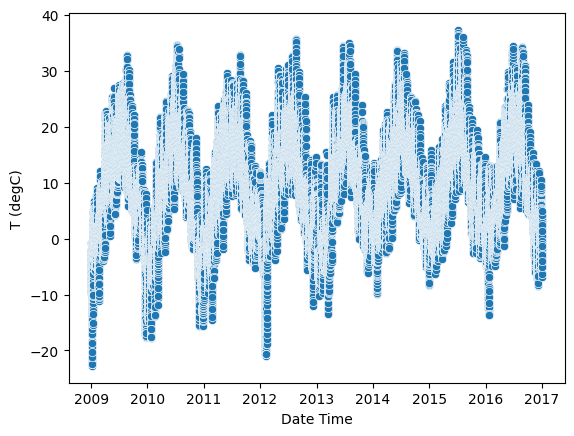

In [9]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
temp = df['T (degC)']
T_plot = sns.scatterplot(data=temp)
sns.set(rc={"figure.figsize":(16, 4)})
T_plot.figure.savefig("/T_plot.png")

Vemos que los datos tienen cierta regularidad. Debería ser posible hacer una predicción. Preparando la data para el forecast, tenemos que lograr esto, en nuestra serie de tiempo: 

In [10]:
# [[[1],[2],[3],[4],[5]]]   [6] 
# [[[2],[3],[4],[5],[6]]]   [7]
# [[[3],[4],[5],[6],[7]]]   [8]
#         X                  y

"X" tiene la forma de 'lista de listas', donde para cada línea, la serie de tiempo se desplaza en una unidad. Lo mismo ocurre para la columna "y". Creamos una función que transforma el dataframe de temp en "X" e "y".   

In [11]:
def df_to_X_y(df, window_size=5): #El ws corresponde a el largo del row, podría no ser siempre igual. 
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row) # Agregamos la lista en X
        label = df_as_np[i+5]
        y.append(label) # Agregamos el elemento que corresponde en y
    return np.array(X), np.array(y)

El length de X es el window_size. 

In [12]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((70086, 5, 1), (70086,))

El shape de X es (N° de filas, N° de col, elementos). Si vemos el dataframe temp, no concuerda la cantidad de datos (70091) con el shape de X (70086). Esto es, porque los últimos 5 terminos de temp no alcanzan a 'iterar' en la función. Ahora definimos los valores de entrenamiento:      

In [13]:
X_train, y_train = X[:60000], y[:60000] 
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

Acá, entrenaremos con los primeros 60000 términos. La segunda línea es de validación 60000-65000, estos datos son ocupados por el algoritmo para ajustar sus propios parámetros en cada 'epoch' y dismimuir el error. La tercera línea es de testeo, la usaremos para ver como predice nuestro forecast respecto a datos reales. Importamos los paquetes necesarios y llamamos a nuestro modelo 'model1' que tendrá los parámetros para realizar el forecast.              

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1= Sequential() #Keras es una API secuencial 
model1.add(InputLayer((5, 1))) #Especificamos el 'shape' de X
model1.add(LSTM(64)) # Especificamos la dimensionalidad del espacio de salida
model1.add(Dense(8, 'relu'))     
model1.add(Dense(1, 'linear'))

model1.summary()

2023-07-23 23:49:39.308520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-23 23:49:39.308563: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-23 23:49:39.308584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-2bea62e9-8d22-46a6-9eb4-51194a5da2d7): /proc/driver/nvidia/version does not exist
2023-07-23 23:49:39.308875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "sequential"
________________________________________________________

Acá las instrucciones Dense(UNITS,ACTIVATION) (fully-connected layer) indica que las neuronas de la iteración x están conectadas con todas las neuronas de la iteración x+1. UNITS:It is the most primitive of all the parameters. It accepts only a positive integer and defines the size of the output vector from the dense layer,i.e., determines the size of the weight matrix along with the bias vector. ACTIVATION: It helps define the activation function that can be applied per element of a dense layer. There are various types of activation functions provided by Keras, such as relu, sigmoid, softmax, Selu, Elu, Tanh, and many more. If not specified, it uses a linear activation function. Finalmente lo importante es que comenzamos con una red neuronal de muchos parámetros, la función Dense (8) y Dense (1) solo nos entrega uno, como resultado de la predicción. Ahora creamos un CheckPoint y generamos el compilador,  

In [15]:
cp = ModelCheckpoint('model1/', save_best_only=True) #Solo guarda la iteración que tenga el menor 'validation loss' 
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

El optimizer es crucial para determinar la precisión de la predicción, acá dejo una descripción de cada posibilidad: https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/ , el learning_rate es un valor que si lo aumentamos, el modelo logrará reducir más rapidamente el 'validation loss', pero no siempre un valor alto es más óptimo, depende del dataset. Ahora entrenamos el modelo y generamos la predicción. La predicción quedará guardada en la carpeta 'model1'.  

In [16]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, callbacks=[cp])

Epoch 1/10
1873/1875 [============================>.] - ETA: 0s - loss: 33.2520 - root_mean_squared_error: 5.7665WARNING:absl:Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model1/assets
1875/1875 [==============================] - 21s 10ms/step - loss: 33.2220 - root_mean_squared_error: 5.7639 - val_loss: 1.2913 - val_root_mean_squared_error: 1.1363
Epoch 2/10
1868/1875 [============================>.] - ETA: 0s - loss: 2.1362 - root_mean_squared_error: 1.4616WARNING:absl:Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to:

Importamos la data guardada. 

In [17]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/') 

Creamos un dataset con una columna de predicción del test y otra columna con los datos reales.

In [18]:
train_predictions = model1.predict(X_train).flatten() #EL shape del X_train es array[[],[]...] por eso aplicamos flatten  
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results 

1875/1875 [==============================] - 7s 3ms/step


,Train Predictions,Actuals
0,-9.853898,-9.67
1,-9.596207,-9.17
2,-8.758612,-8.10
3,-7.334740,-7.66
4,-7.202026,-7.04
...,...,...
59995,6.082334,6.07
59996,7.306714,9.88
59997,12.255781,13.53
59998,16.037083,15.43


Graficamos juntos, los 500 primeros datos reales y datos predichos del entrenamiento.  

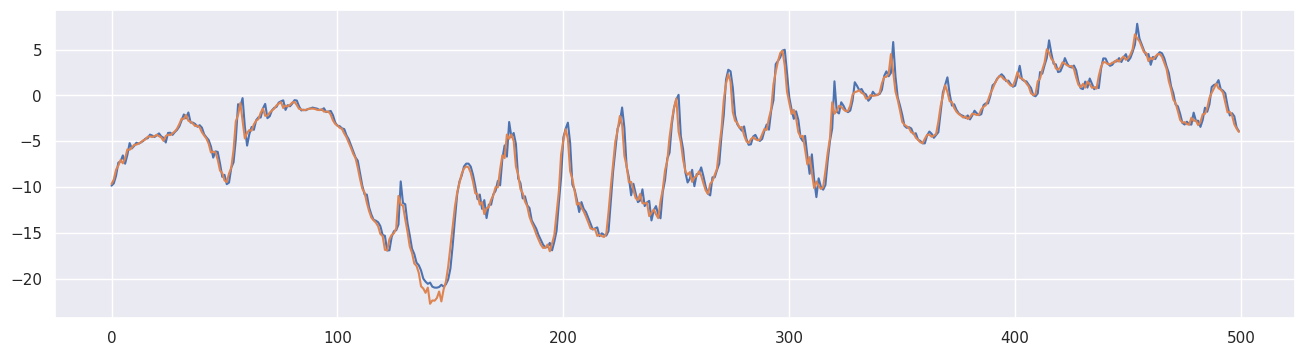

In [19]:
import matplotlib.pyplot as plt
p=plt.plot(train_results['Train Predictions'][:500])
r=plt.plot(train_results['Actuals'][:500])

Creamos un dataframe con los datos de validación que utilizó la red neuronal para disminuir el 'validation loss'. Vemos gráficamente, como se comportan los datos reales con los de validación.    

157/157 [==============================] - 1s 3ms/step


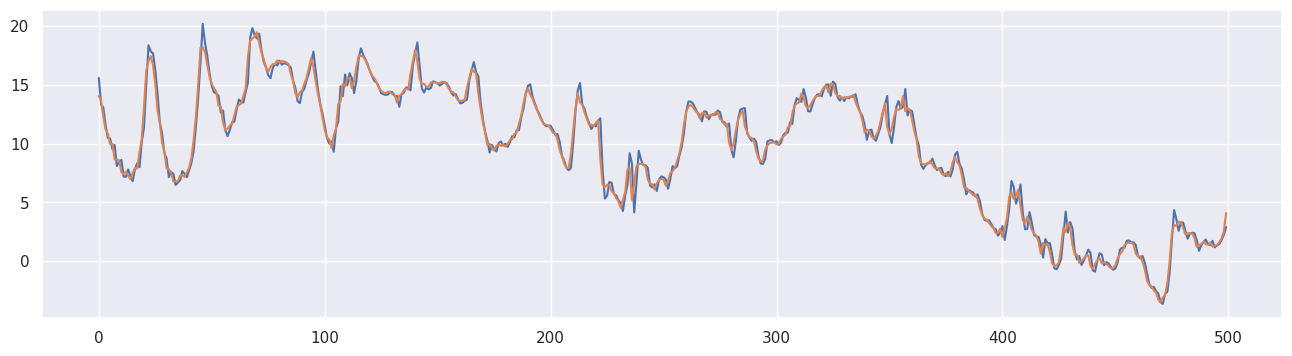

In [20]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
plt.plot(val_results['Val Predictions'][:500])
plt.plot(val_results['Actuals'][:500])

Ahora estudiamos como se comportan los datos predichos con los reales.  

159/159 [==============================] - 1s 3ms/step


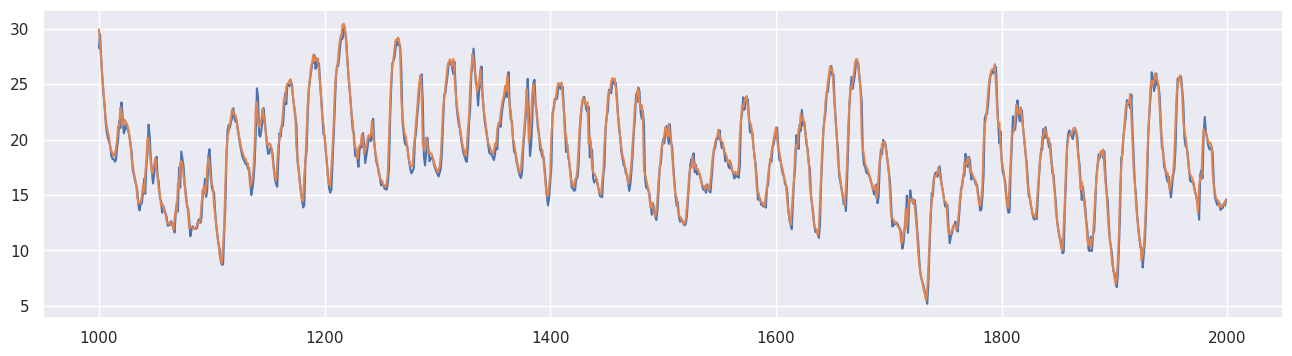

In [21]:
train_tests = model1.predict(X_test).flatten()  
train_test_results = pd.DataFrame(data={'Train Test Predictions':train_tests, 'Actuals':y_test})
plt.plot(train_test_results['Train Test Predictions'][1000:2000])
plt.plot(train_test_results['Actuals'][1000:2000])

Condensamos todo en una sola función, para mostrar el dataframe, el 'mean squared error' y el gráfico. 

In [22]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions) 

159/159 [==============================] - 1s 3ms/step


(      Predictions  Actuals
 0       14.406353    13.99
 1       13.288279    13.46
 2       12.890416    12.93
 3       12.502106    12.43
 4       12.074863    12.17
 ...           ...      ...
 5081    -1.090823    -0.98
 5082    -1.484326    -1.40
 5083    -1.670205    -2.75
 5084    -3.111462    -2.89
 5085    -3.080701    -3.93
 
 [5086 rows x 2 columns],
 0.61688227327404)

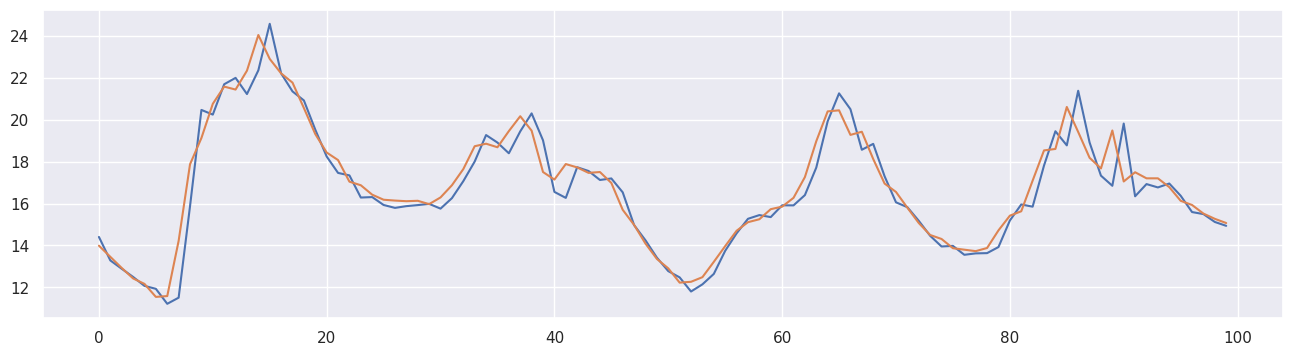

In [23]:
plot_predictions1(model1, X_test, y_test)

## Diferentes modelos, más variables

### Modelo Conv1D 

Conv es un modelo para matrices en 2d pero podemos utilizarlo en 1d también, tenemos que considerar los parámetros correctos (Los parámetros pueden ser consultados ejecutando model.summary()). La ventaja es que la cantidad de parámetros de este modelo es más baja, con respecto a LSTM. Esto nos da ventaja desde el punto de vista computacional (se ejecuta más rápido). 

In [24]:
model2= Sequential() 
model2.add(InputLayer((5, 1))) #El window size es 5. Los datos a predecir es 1.     
model2.add(Conv1D(64,kernel_size=2)) 
model2.add(Flatten())
model2.add(Dense(8, 'relu'))     
model2.add(Dense(1, 'linear'))

cp2 = ModelCheckpoint('model2/', save_best_only=True)  
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp2], verbose=0)

INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets
INFO:tensorflow:Assets written to: model2/assets


159/159 [==============================] - 0s 1ms/step


(      Predictions  Actuals
 0       14.501948    13.99
 1       13.325147    13.46
 2       12.999084    12.93
 3       12.564202    12.43
 4       12.132524    12.17
 ...           ...      ...
 5081    -1.669380    -0.98
 5082    -1.579023    -1.40
 5083    -1.665247    -2.75
 5084    -3.353889    -2.89
 5085    -3.060645    -3.93
 
 [5086 rows x 2 columns],
 0.6532126986617092)

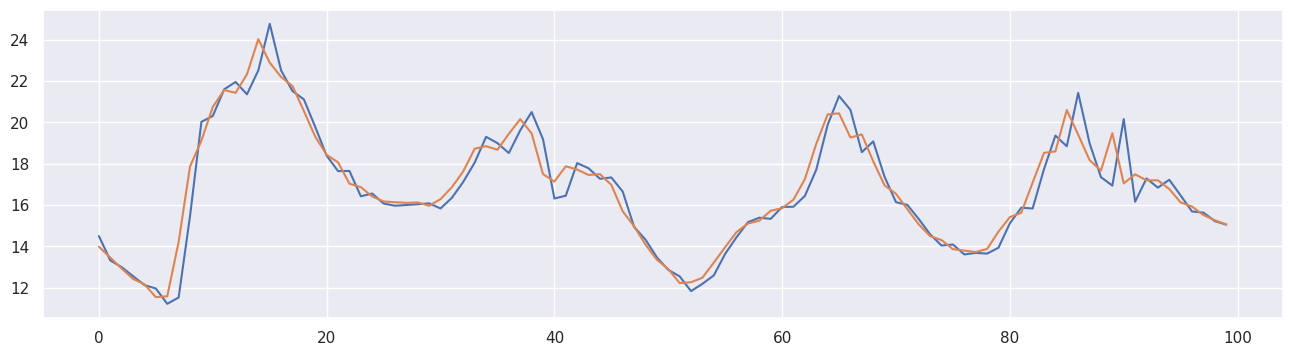

In [25]:
plot_predictions1(model2, X_test, y_test)

### Modelo GRU

Consideramos un nuevo modelo, GRU. Este modelo tiene menos parámetros respecto a LSTM, pero más respecto a Conv1D.   

In [26]:
model3= Sequential() 
model3.add(InputLayer((5, 1))) 
model3.add(GRU(64)) 
model3.add(Flatten())
model3.add(Dense(8, 'relu'))     
model3.add(Dense(1, 'linear'))

cp3 = ModelCheckpoint('model3/', save_best_only=True)  
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp3], verbose=0)

INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets
INFO:tensorflow:Assets written to: model3/assets


159/159 [==============================] - 1s 3ms/step


(      Predictions  Actuals
 0       14.399292    13.99
 1       13.244484    13.46
 2       12.901747    12.93
 3       12.481853    12.43
 4       12.046527    12.17
 ...           ...      ...
 5081    -0.703860    -0.98
 5082    -1.296290    -1.40
 5083    -1.658213    -2.75
 5084    -3.351182    -2.89
 5085    -3.363781    -3.93
 
 [5086 rows x 2 columns],
 0.6181046410972143)

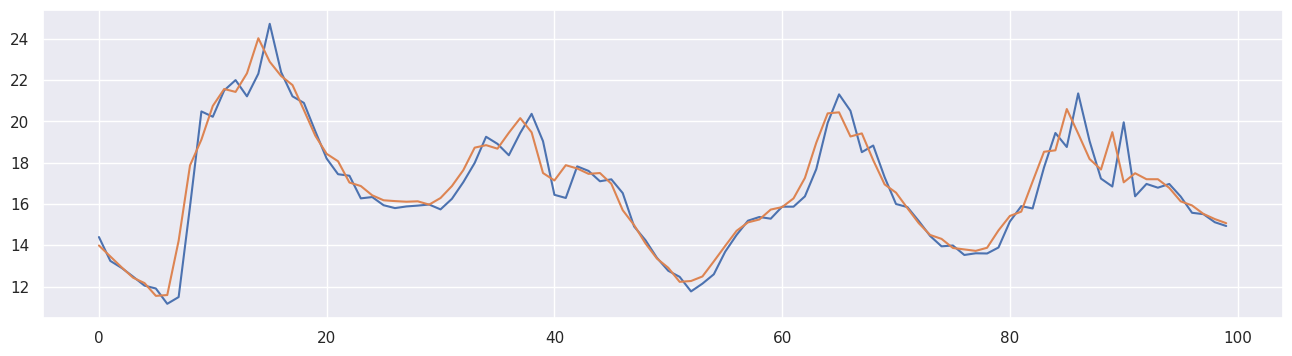

In [27]:
plot_predictions1(model3, X_test, y_test)

### Adición de variables temporales

Agregamos variables temporales adicionales en segundos al dataframe. Esto, porque la variable temporal está claramente correlacionada con la forma que varía la temperatura (por ejemplo en invierno la temperatura es mínima y en verano es máxima). La correlación también se observa en un día, durante el mediodía la temperatura es máxima y en la noche es mínima. La función para transformar la variable temporal, tiene que ser sinusoidal, ya que las temperaturas también siguen esta forma. Si logramos que la variable temporal tenga una correlación con la temperatura, esto ayudará al modelo a decrecer su validation loss de manera más eficiente.      

In [28]:
temp_df = pd.DataFrame({'Temperature':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp) 
temp_df

,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


Vemos que los segundos parten desde un valor muy grande. Para nuestro cálculo, no es necesario cambiarlo. Si fuera necesario cambiar el tiempo en segundos, solamente tenemos que hacer un shift de los segundos fijando el cero en el primer término.  

Agregamos nuevas columnas al dataframe, donde ponemos las sinusoidales aplicadas a la variable temporal. Aplicamos las función sin y cos en la variable temporal de la siguiente manera:

T_day(t) = Sin(t * 2 pi / day),    T_day(t) = Cos(t * 2 pi / day),   T_year(t) = Sin(t * 2 pi / year),    T_year = Cos(t* 2 pi / year)   

Claramente, day y year dentro de las funciones son el período de las funciones temporales.    

In [29]:
day = 60*60*24
year = 365.2425*day

temp_df['Day sin']= np.sin(temp_df['Seconds']* (2 * np.pi / day))
temp_df['Day cos']= np.cos(temp_df['Seconds']* (2 * np.pi / day))
temp_df['Year sin']= np.sin(temp_df['Seconds']* (2 * np.pi / year))
temp_df['Year cos']= np.cos(temp_df['Seconds']* (2 * np.pi / year))
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()


,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917


Creamos la matriz de entrenamiento, junto a las variables extras de tiempo, la matriz tiene que ser de las siguiente forma:  

In [30]:
# [[[t1, ds1],[t2, ds2],[t3, ds3],[t4, ds4],[t5, ds5]]]   [t6] 
# [[[t2, ds2],[t3, ds3],[t4, ds4],[t5, ds5],[t6, ds6]]]   [t7]
# [[[t3, ds3],[t4, ds4],[t5, ds5],[t6, ds6],[t7, ds7]]]   [t8]
#                         X                                 y

Como vemos, las funciones temporales sinusoidales, entran solamente a la matriz de entrenamiento. Generamos la matriz X, con el siguiente código:       

In [31]:
def df_to_X_y2(df, window_size=6): 
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row) 
        label = df_as_np[i+window_size][0]
        y.append(label) 
    return np.array(X), np.array(y)

Transformamos nuestro dataframe y verificamos el shape de la matriz X y el vector a predecir y. 

In [32]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((70085, 6, 5), (70085,))

Definimos los valores de entrenamiento, de validación y de testeo. Verificamos el shape de los valores.   

In [33]:
X2_train, y2_train = X2[:60000], y2[:60000] 
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape  

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

Para nuestros datos tenemos que aplicar 'standarization'. Esto es porque los valores de temperatura y de tiempo tienen una disparidad importante. Si aplicamos el modelo de esta forma, durante el entrenamiento podría dar una mayor énfasis a variaciones de temperatura que el resto de variables. Esto es así, porque las variaciones de esas variables de temperatura son mayores. Definimos una función de preprocesamiento de los datos de entrenamiento. Esta función cambia los valores en torno al valor promedio, obteniendo valores similares entre todas las variables.     

In [34]:
temp_training_mean = np.mean(X2_train[:, :,0])
temp_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0]-temp_training_mean ) / temp_training_std
    return X

In [35]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 1.04009706e+00, -9.65925826e-01,  2.58819045e-01,
          5.22877889e-01, -8.52407598e-01],
        [ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
          5.20431780e-01, -8.53903251e-01],
        [ 5.37051663e-01, -7.16474371e-12,  1.00000000e+00,
          5.19819584e-01, -8.54276068e-01]],

       [[ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
  

Como ya tenemos nuestros datos preprocesados, aplicaremos el modelo LSTM con los datos temporales.   

In [36]:
model4= Sequential() 
model4.add(InputLayer((6, 5))) # 6 Layers y 5 variables de interes   
model4.add(LSTM(64)) 
model4.add(Dense(8, 'relu'))     
model4.add(Dense(1, 'linear'))

cp4 = ModelCheckpoint('model4/', save_best_only=True)  
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4], verbose=0)

INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets
INFO:tensorflow:Assets written to: model4/assets


Vemos como se comporta nuestro forecast: 

159/159 [==============================] - 1s 4ms/step


(      Predictions  Actuals
 0       13.251894    13.46
 1       12.844282    12.93
 2       12.451992    12.43
 3       12.179411    12.17
 4       12.317805    11.55
 ...           ...      ...
 5080    -1.016048    -0.98
 5081    -1.375858    -1.40
 5082    -1.615852    -2.75
 5083    -2.978072    -2.89
 5084    -3.045754    -3.93
 
 [5085 rows x 2 columns],
 0.4815087340423746)

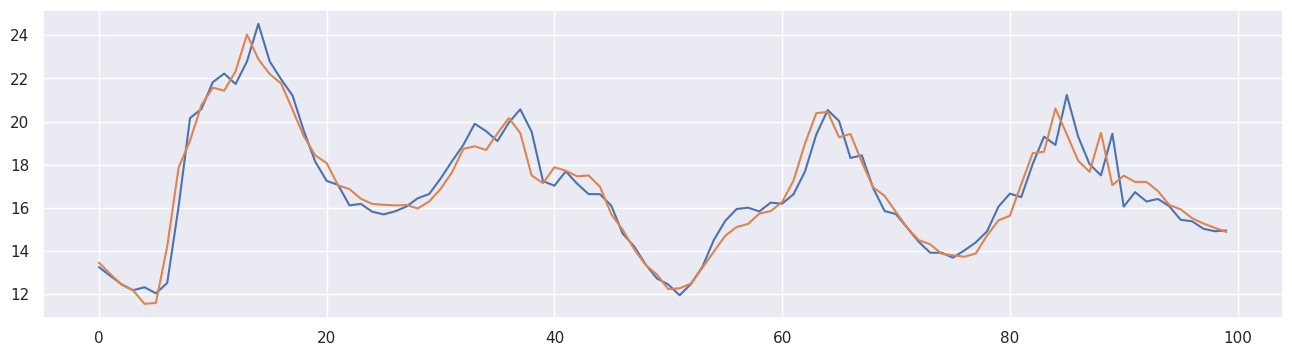

In [37]:
plot_predictions1(model4, X2_test, y2_test)

Vemos un MSE aún mas bajo ~0.5. Ahora introducimos la variable de presión al forecast. En este caso, la presión también será un output, teniendo así 2 outputs del forecast. En este caso también consideraremos las funciones temporales del forecast anterior.    

In [38]:
p_temp_df = pd.concat([df['p (mbar)'],temp_df], axis=1)
p_temp_df

,p (mbar),Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...
2016-12-31 19:10:00,1002.18,-0.98,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,1001.40,-1.40,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,1001.19,-2.75,-0.675590,0.737277,0.008334,0.999965


In [39]:
def df_to_X_y3(df, window_size=7): 
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row) 
        label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1]]
        y.append(label) 
    return np.array(X), np.array(y)

In [40]:
X3, y3 = df_to_X_y3(p_temp_df)
X3.shape, y3.shape

((70084, 7, 6), (70084, 2))

In [41]:
X3_train, y3_train = X3[:60000], y3[:60000] 
X3_val, y3_val = X3[60000:65000], y3[60000:65000]
X3_test, y3_test = X3[65000:], y3[65000:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape  

((60000, 7, 6), (60000, 2), (5000, 7, 6), (5000, 2), (5084, 7, 6), (5084, 2))

In [42]:
p_training_mean3 = np.mean(X3_train[:, :, 0])
p_training_std3 = np.std(X3_train[:, :, 0])

temp_training_mean3 = np.mean(X3_train[:, :, 1])
temp_training_std3 = np.std(X3_train[:, :, 1])

def preprocess3(X):
    X[:, :, 0] = (X[:, :, 0] - p_training_mean3) / p_training_std3
    X[:, :, 1] = (X[:, :, 1] - temp_training_mean3) / temp_training_std3
    return X

def preprocess_output3(y):
    y[:, 0] = (y[:, 0] - p_training_mean3) / p_training_std3
    y[:, 1] = (y[:, 1] - temp_training_mean3) / temp_training_std3
    return y

In [43]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

array([[[-1.07355644e+00,  1.04009390e+00, -9.65925826e-01,
          2.58819045e-01,  5.22877889e-01, -8.52407598e-01],
        [-1.00807435e+00,  9.90728707e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-9.51080673e-01,  8.49685305e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        ...,
        [-8.80748054e-01,  6.66328883e-01, -2.58819045e-01,
          9.65925826e-01,  5.20431780e-01, -8.53903251e-01],
        [-8.29817537e-01,  5.37039098e-01, -7.16474371e-12,
          1.00000000e+00,  5.19819584e-01, -8.54276068e-01],
        [-8.01927015e-01,  4.74744929e-01,  2.58819045e-01,
          9.65925826e-01,  5.19207120e-01, -8.54648446e-01]],

       [[-1.00807435e+00,  9.90728707e-01, -8.66025404e-01,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-9.51080673e-01,  8.49685305e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        [-9.14701

In [44]:
preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

array([[-0.7934386 ,  0.41245076],
       [-0.76312281,  0.35368268],
       [-0.72189335,  0.32312327],
       ...,
       [ 1.48145784, -1.43051636],
       [ 1.41597574, -1.44697142],
       [ 1.35049365, -1.56920903]])

In [45]:
model5= Sequential() 
model5.add(InputLayer((7, 6))) # 7 Layers y 6 variables de interes   
model5.add(LSTM(64)) 
model5.add(Dense(8, 'relu'))     
model5.add(Dense(2, 'linear')) #ahora es 2, por las 2 variables del output 

cp5 = ModelCheckpoint('model5/', save_best_only=True)  
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp5], verbose=0)

INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets
INFO:tensorflow:Assets written to: model5/assets


Creamos una función para plotear todo lo que hemos hecho, al mismo tiempo

In [46]:
def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
    p_actuals, temp_actuals = y[:, 0], y[:, 1]
    df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                            'Temperature Actuals': temp_actuals,
                            'Pressure Predictions':p_preds,
                            'Pressure Actuals':p_actuals})
    plt.plot(df['Temperature Predictions'][start:end]) 
    plt.plot(df['Temperature Actuals'][start:end])
    plt.plot(df['Pressure Predictions'][start:end])
    plt.plot(df['Pressure Actuals'][start:end])
    return df[start:end] 

159/159 [==============================] - 1s 4ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,0.373914,0.412451,-0.793671,-0.793439
1,0.332207,0.353683,-0.783692,-0.763123
2,0.293945,0.323123,-0.749825,-0.721893
3,0.302976,0.250251,-0.696563,-0.652773
4,0.261127,0.254952,-0.609308,-0.652773
...,...,...,...,...
95,0.661450,0.716869,-0.420873,-0.416310
96,0.622529,0.687485,-0.423652,-0.399333
97,0.607877,0.663978,-0.406142,-0.399333
98,0.613703,0.641646,-0.393626,-0.400546


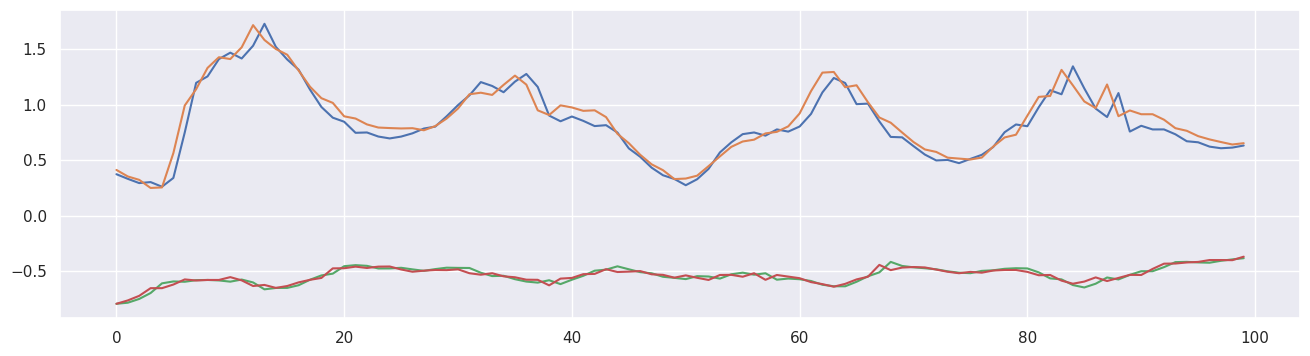

In [47]:
plot_predictions2(model5, X3_test, y3_test)

Los valores obtenidos son los normalizados. Tenemos que deshacer la normalización. 

In [48]:
def postprocess_temp(arr): 
    arr = (arr * temp_training_std3) + temp_training_mean3
    return arr

def postprocess_p(arr): 
    arr = (arr * p_training_std3) + p_training_mean3
    return arr

In [49]:
def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    p_preds, temp_preds = postprocess_p(predictions[:, 0]), postprocess_temp(predictions[:, 1])
    p_actuals, temp_actuals = postprocess_p(y[:, 0]), postprocess_temp(y[:, 1])
    df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                            'Temperature Actuals': temp_actuals,
                            'Pressure Predictions':p_preds,
                            'Pressure Actuals':p_actuals})
    plt.plot(df['Temperature Predictions'][start:end]) 
    plt.plot(df['Temperature Actuals'][start:end])
    plt.plot(df['Pressure Predictions'][start:end])
    plt.plot(df['Pressure Actuals'][start:end])
    return df[start:end] 

In [51]:
model6 = Sequential()
model6.add(InputLayer((7, 6)))
model6.add(LSTM(32, return_sequences=True))
model6.add(LSTM(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(2, 'linear'))

cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model6.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp6], verbose=0)

INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets
INFO:tensorflow:Assets written to: model6/assets


In [52]:
model7 = Sequential()
model7.add(InputLayer((7, 6)))
model7.add(Conv1D(64, kernel_size=2, activation='relu'))
model7.add(Flatten())
model7.add(Dense(8, 'relu'))
model7.add(Dense(2, 'linear'))

cp7 = ModelCheckpoint('model7/', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model7.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp7], verbose=0)

INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets
INFO:tensorflow:Assets written to: model7/assets


## Conclusiones

A continuación hacemos un dataframe comparativo, resumiendo los Mean Squared Error (MSE) de todas nuestras predicciones,     

In [70]:
def PredMSE(model, X, y):
    predictions = model.predict(X).flatten()
    return mse(y, predictions) 

def PredMSEb(model, X, y):
    predictions = model.predict(X)
    temp_preds = postprocess_temp(predictions[:, 1])
    temp_actuals = postprocess_temp(y[:, 1])
    return mse(temp_actuals, temp_preds)     

df_Summ = pd.DataFrame({'Modelos': ['LSTM(64)','Conv1D(64)','GRU(64)','LSTM(64)-TF','LSTM(64)-TF-P','LSTM(32)-LSTM(64)-TF-P','Conv1D(64)-TF-P'], 'Mean Squared Error': [PredMSE(model1,X_test,y_test), PredMSE(model2,X_test,y_test), PredMSE(model3,X_test,y_test), PredMSE(model4,X2_test,y2_test), PredMSEb(model5,X3_test,y3_test),PredMSEb(model6,X3_test,y3_test), PredMSEb(model7,X3_test,y3_test)]})
df_Summ

159/159 [==============================] - 0s 1ms/step


,Modelos,Mean Squared Error
0,LSTM(64),0.616882
1,Conv1D(64),0.653213
2,GRU(64),0.618105
3,LSTM(64)-TF,0.481509
4,LSTM(64)-TF-P,0.491668
5,LSTM(32)-LSTM(64)-TF-P,0.479029
6,Conv1D(64)-TF-P,0.504584


graficando,

Text(0.5, 1.0, 'Models MSE Comparison')

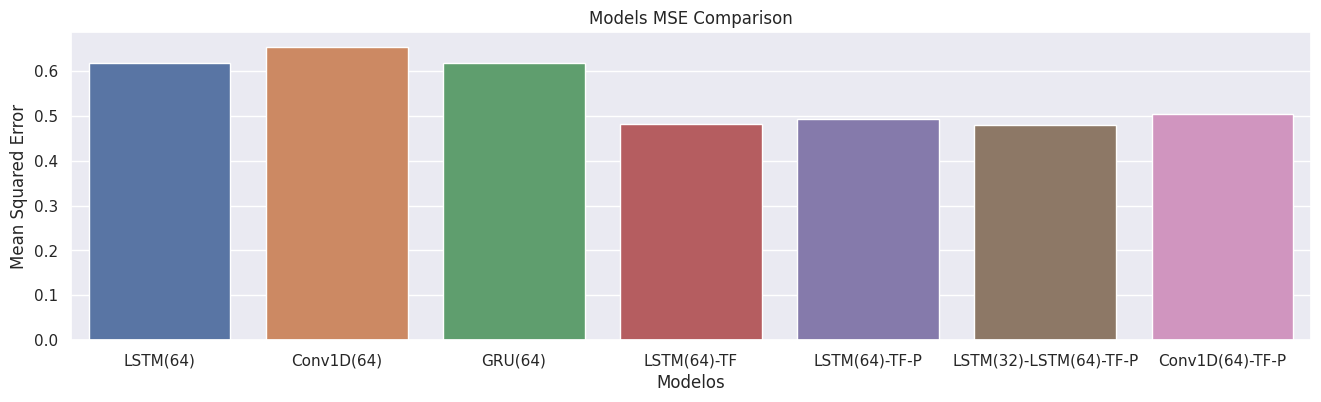

In [71]:
sns.barplot(data=df_Summ,x='Modelos',y='Mean Squared Error')
plt.title('Models MSE Comparison')

Vemos un menor error en el modelo LSTM(32)-LSTM(64)-TF-P, en este modelo aplicamos un forecast en cadena LSTM(32) e inmediatamente después un LSTM(64), en este caso consideramos los outputs a testear Temperatura y Presión. Definitivamente, para cualquiera de estos casos es mandatorio aplicar la función temporal al tiempo, agregar este recurso mejora considerablemente el MSE y el algoritmo toma menos tiempo en converger a un valor de MSE adecuado.                   

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2bea62e9-8d22-46a6-9eb4-51194a5da2d7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>